# ImageContainer class
Squidpy provides an `ImageContainer` class that wraps `Xarray` to store several high-resolution images in the same coordinate system. It can be instanciated from a `.tif` or `.jpeg` file or a numpy array. For `.tif`, it supports lazy loading, only reading the data when necessary. The images are saved as a `xarray.Dataset` in the `.data` attribute.

The `ImageContainer` contains methods for extracting crops from the images, which can be e.g. used to generate image crops centered on visium spots.

This notebook showcases the different methods of `ImageContainer`.


In [1]:
# import modules
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import squidpy as sq

## Init ImageContainer
The constructor takes as input a path to an image on disk, or a numpy array. The loaded image will be stored in a layer in the `xarray.Dataset` with the name `img_id`. By default the name is `image`. The `lazy` argument controls if images are loaded in memory directly, or lazily.

In [2]:
# TODO: show image loading

`read_visium_data` is a convenience function that loads both the AnnData object and the ImageContainer object from a given folder containing a visium dataset. 
Internally, it calls `ImageContainer()` with default aguments.

In [3]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla")
# load data
adata, img = sq.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/hannah.spitzer/opt/miniconda3/envs/spatial-scanpy/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


## ImageContainer is a wrapper around xarray.Dataset
The loaded image is contained in `img.data`, which is an `xarray.Dataset`. 

In [4]:
adata

AnnData object with n_obs × n_vars = 2698 × 31053
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
print(img)
display(img.data)

ImageContainer object with 1 layers.
    image: channels (3), y (11757), x (11291)



<xarray.Dataset>
Dimensions:   (channels: 3, x: 11291, y: 11757)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: x, y
Data variables:
    image     (channels, y, x) uint8 129 129 129 129 128 ... 130 130 133 131 128

You can add more images to `img` by calling `add_img()`. The added images need to have the same x and y coordinates as the original image, but can have different channel dimensions.
This is useful when you have e.g. an RGB Histology image and would like to add a binary segmentation mask to `img`.

In [6]:
# create dummy mask, with dimensions channels, y, x
mask = np.zeros([1, img.shape[1], img.shape[0]])
# add mask to img
img.add_img(mask, img_id='mask', channel_id='segmentation')

print(img)
display(img.data)

ImageContainer object with 2 layers.
    image: channels (3), y (11757), x (11291)
    mask: segmentation (1), y (11757), x (11291)



<xarray.Dataset>
Dimensions:   (channels: 3, segmentation: 1, x: 11291, y: 11757)
Coordinates:
  * channels  (channels) int64 1 2 3
Dimensions without coordinates: segmentation, x, y
Data variables:
    image     (channels, y, x) uint8 129 129 129 129 128 ... 130 130 133 131 128
    mask      (segmentation, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

## Extract crops
`crop_center` and `crop_corner` extract a single crop from the specified `img_id`. Use `crop_center` if you would like to extract crops centered around a given pixel, and `crop_corner` if you are cropping from the upper left corner coordinates.

In [7]:
crop = img.crop_center(3000,4000, xr=100, yr=100, img_id='image')

The resulting crop is a `xarray.DataArray` with dimensions `channels`, `y`, `x`.

In [8]:
display(crop)

<xarray.DataArray (channels: 3, y: 201, x: 201)>
array([[[110, 103,  85, ..., 137, 144, 161],
        [123, 122, 107, ..., 128, 146, 151],
        [135, 126, 119, ..., 118, 130, 138],
        ...,
        [ 71,  72,  90, ..., 132, 125, 117],
        [ 68,  69,  88, ..., 136, 135, 127],
        [ 60,  64,  83, ..., 144, 136, 139]],

       [[ 92,  86,  70, ...,  95, 106, 122],
        [106, 103,  91, ...,  87, 106, 112],
        [117, 108, 103, ...,  77,  87,  96],
        ...,
        [ 48,  52,  61, ..., 105,  98,  92],
        [ 51,  52,  64, ..., 112, 111, 105],
        [ 46,  51,  63, ..., 121, 114, 118]],

       [[112, 112,  95, ..., 130, 137, 153],
        [120, 121, 107, ..., 123, 139, 144],
        [128, 120, 114, ..., 117, 128, 133],
        ...,
        [ 93,  96, 108, ..., 129, 123, 115],
        [ 94,  95, 110, ..., 131, 131, 122],
        [ 87,  92, 106, ..., 138, 130, 133]]], dtype=uint8)
Dimensions without coordinates: channels, y, x

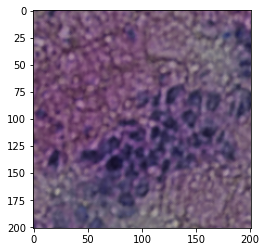

In [9]:
plt.imshow(crop.transpose('y', 'x', ...).data)

## Extract crops using crop_spot_generator
We can crop a series of images using the `crop_spot_generator`. This generates crops that are centered on the visium spots defined in `adata`. For each spot it returns `(obs_id, crop)`.
Per default, the crop has the size of the spot diameter.

In [10]:
crop_iter = img.crop_spot_generator(adata)
obs_id, crop = next(crop_iter)
print(obs_id, crop.shape)

AAACAAGTATCTCCCA-1 (3, 89, 89)


Lets plot the location of the obs that we have just cropped

8230 7237


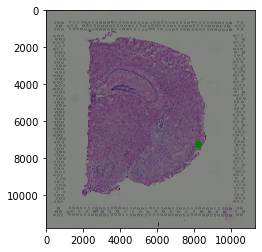

In [11]:
x , y = adata[obs_id].obsm['spatial'][0]
print(x, y)
plt.scatter(x, y, c='green')
plt.imshow(img.data['image'].transpose('y', 'x', ...).data)

### Extract crops with more context
Use the `size` argument to extract crops with a larger neighbourhood.
Note that the function will add `cval` (0 by default) when the range is outside the image.

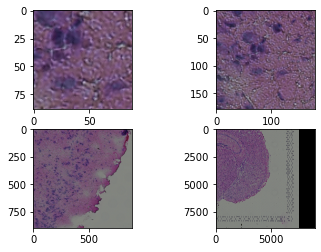

In [12]:
fig, axes = plt.subplots(2,2)
for ax, size in zip(axes.flat, [1,2,10,100]):
    obs_id, crop = next(img.crop_spot_generator(adata, size=size, cval=0))
    ax.imshow(crop.transpose('y','x',...).data)

### Extract crops with different scales
We can downscale the extracted crops using the `scale` argument.

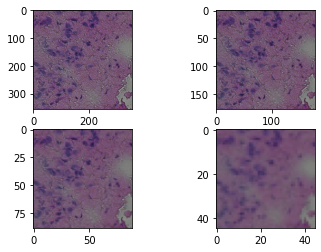

In [13]:
fig, axes = plt.subplots(2,2)
for ax, scale in zip(axes.flat, [1,0.5,0.25,0.125]):
    obs_id, crop = next(img.crop_spot_generator(adata, size=4, scale=scale))
    ax.imshow(crop.transpose('y','x',...).data)

### Mask crops with circle
In order to make sure that features are only calculated on the tissue which was under the visium spot, use the `mask_circle` argument. This can also be combined with different `size`s and `scale`s.

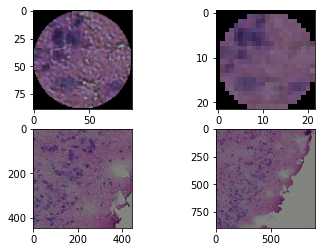

In [14]:
_, crop_1 = next(img.crop_spot_generator(adata, size=1, scale=1, mask_circle=True))
_, crop_2 = next(img.crop_spot_generator(adata, size=1, scale=0.25, mask_circle=True))
_, crop_3 = next(img.crop_spot_generator(adata, size=5, scale=1))
_, crop_4 = next(img.crop_spot_generator(adata, size=10, scale=1))

fig, axes = plt.subplots(2,2)
axes[0][0].imshow(crop_1.transpose('y','x',...).data)
axes[0][1].imshow(crop_2.transpose('y','x',...).data)
axes[1][0].imshow(crop_3.transpose('y','x',...).data)
axes[1][1].imshow(crop_4.transpose('y','x',...).data)


# Extract crops using a fluorescence dataset

In [16]:
# set path to dataset
BASE_PATH = "../../data"
dataset_folder = os.path.join(BASE_PATH, "2020_10XFluoVisium_MouseBrain2_giovanni.palla")
adata, img = sq.read_visium_data(dataset_folder)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Multi-page tiff images with 1 channel (like this fluorescence tiff) are automatically merged in one data array. Cropping will return each fluoresecent image as a channel

In [17]:
img.data

<xarray.Dataset>
Dimensions:   (channels: 3, x: 24240, y: 24240)
Coordinates:
  * channels  (channels) int64 1 1 1
Dimensions without coordinates: x, y
Data variables:
    image     (channels, y, x) uint16 1644 1616 1628 1628 1664 ... 0 0 0 0 0

When cropping, we need to manually set the dtype to be uint8 to allow plotting with matplotlib

(3, 179, 179) uint8


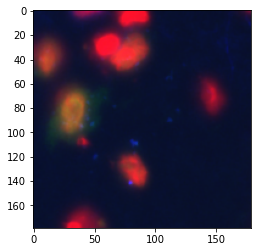

In [18]:
obs_id, crop = next(img.crop_spot_generator(adata, dtype='uint8'))
print(crop.shape, crop.dtype)
plt.imshow(crop.transpose('y','x',...).data)

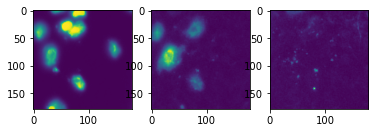

In [19]:
fig, axes = plt.subplots(1,3)
for i, ax in enumerate(axes.flat):
    ax.imshow(crop[i])